In [92]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import torch as torch
from torch.utils.data import Dataset
from tqdm import tqdm
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
path = "/om2/user/jackking/modular_transformers/scripts/dimensionality_reduction"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [94]:
class LMDataset(Dataset):
    def __init__(self, inputs, attn_mask=None, labels=None):
        #cast to tensors if not already tensors
        if not torch.is_tensor(inputs):
            inputs = torch.tensor(inputs)
        if not torch.is_tensor(labels):
            labels = torch.tensor(labels)
        if attn_mask is not None and not torch.is_tensor(attn_mask):
            attn_mask = torch.tensor(attn_mask)
            
        self.inputs = inputs
        self.attn_mask = attn_mask
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.labels is None:
            item = {
                'input_ids': self.inputs[idx],
                'attention_mask': self.attn_mask[idx]}
        elif self.attn_mask is None:
            item = {
                'input_ids': self.inputs[idx],
                'labels': self.labels[idx]
            }
        else:
            item = {
                'input_ids': self.inputs[idx],
                'attention_mask': self.attn_mask[idx],
                'labels': self.labels[idx]
            }
        return item

def make_autoregressive_dataset(data):
    tokenizer.pad_token = tokenizer.eos_token
    dataset = tokenizer.batch_encode_plus(data, add_special_tokens=True, padding='longest', return_tensors="pt")
    inputs = dataset["input_ids"]
    attn_mask = dataset["attention_mask"]
    labels = dataset["input_ids"].clone()
    context_len = inputs.size(1)
    return LMDataset(inputs, attn_mask, labels), context_len

def make_classification_dataset(data1, data2):
    tokenizer.pad_token = tokenizer.eos_token
    len1 = len(data1)
    len2 = len(data2)
    combined = data1 + data2
    labels = [0]*len1 + [1]*len2
    dataset = tokenizer.batch_encode_plus(combined, add_special_tokens=True, padding='longest', return_tensors="pt")
    inputs = dataset["input_ids"]
    attn_mask = dataset["attention_mask"]
    context_len = inputs.size(1)
    return LMDataset(inputs, attn_mask, torch.tensor(labels)), context_len

In [95]:
def load_data(datatype, sub_datatype, classification, batch_size):

    train_data_path = f"{path}/data/{datatype}/train_data_{sub_datatype}.pkl"
    val_data_path = f"{path}/data/{datatype}/valid_data_{sub_datatype}.pkl"

    with open(train_data_path, "rb") as f:
        train_data = pickle.load(f)
    with open(val_data_path, "rb") as f:
        val_data = pickle.load(f)

    if classification:
        train_labels = train_data["labels"]
        val_labels = val_data["labels"]
    else:
        train_labels = train_data["inputs"]
        val_labels = val_data["inputs"]
    
    train_data = train_data["inputs"]
    val_data = val_data["inputs"]

    trainset = LMDataset(train_data, labels=train_labels)
    valset = LMDataset(val_data, labels=val_labels)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

In [96]:
def evaluate(model, valloader):
    model.eval()
    losses = []
    for step, batch in tqdm(enumerate(valloader), total=len(valloader)):
        with torch.no_grad():
            inputs = batch["input_ids"].to(device)
            if "attention_mask" in batch:
                attention_mask = batch["attention_mask"].to(device)
            else:
                attention_mask = None
            labels = batch["labels"].to(device)
            outputs = model(inputs, labels=labels, attention_mask=attention_mask)
        losses.append(outputs.loss)
    loss = torch.mean(torch.stack(losses))
    return loss.item()

In [97]:
model_name = "azure-plant-15"
datatype = "natural_language"
sub_datatype = "fourgram_A"
model_type = "lm"

model_path = f"{path}/models/{datatype}/{sub_datatype}/{model_type}/{model_name}/epoch_20"
model = GPT2LMHeadModel.from_pretrained(model_path)
model.to(device)

# model_name = "gpt2"
# datatype = "natural_language"
# sub_datatype = "natural"
# model_type = "lm"

# model = GPT2LMHeadModel.from_pretrained("gpt2")
# model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(128, 768)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

100%|██████████| 5000/5000 [00:49<00:00, 100.71it/s]
5000it [02:31, 33.00it/s]


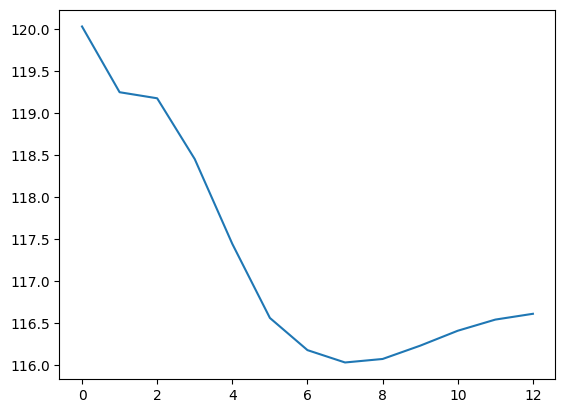

In [98]:
val_data_path = f"{path}/data/{datatype}/valid_data_{sub_datatype}.pkl"
with open(val_data_path, "rb") as f:
    val_data = pickle.load(f)
if sub_datatype == "natural":
    data = val_data
else:
    data = val_data["inputs"]
activations = compute_model_activations(model, data, device)
curvature = compute_model_curvature(activations)
curve = 180 / np.pi * curvature["curve"]
plt.plot(np.nanmean(curve, axis=1))
plt.show()

100%|██████████| 4200/4200 [00:40<00:00, 103.40it/s]
4200it [02:03, 34.06it/s]


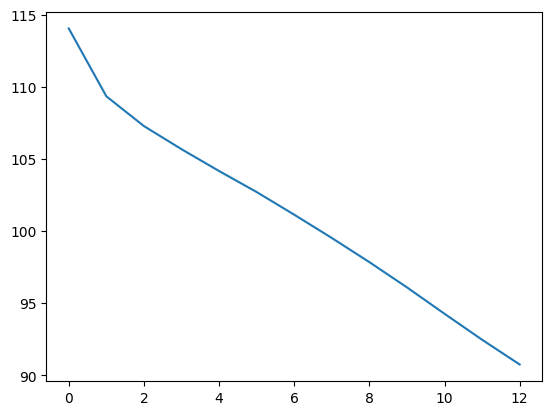

In [7]:
val_data_path = f"{path}/data/{datatype}/valid_data_{sub_datatype}.pkl"
with open(val_data_path, "rb") as f:
    val_data = pickle.load(f)
data = val_data["inputs"]
activations = compute_model_activations(model, data, device)
curvature = compute_model_curvature(activations)
curve = 180 / np.pi * curvature["curve"]
plt.plot(np.nanmean(curve, axis=1))
plt.show()

100%|██████████| 5001/5001 [00:53<00:00, 93.20it/s] 
5001it [02:29, 33.46it/s]


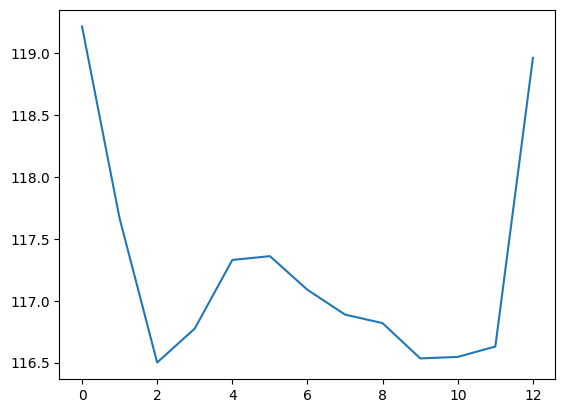

: 

: 

In [6]:
val_data_path = f"{path}/data/{datatype}/valid_data_{sub_datatype}.pkl"
with open(val_data_path, "rb") as f:
    val_data = pickle.load(f)
data = val_data["inputs"]
activations = compute_model_activations(model, data, device)
curvature = compute_model_curvature(activations)
curve = 180 / np.pi * curvature["curve"]
plt.plot(np.nanmean(curve, axis=1))
plt.show()

#toy fourgram

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:42<00:00, 117.88it/s]
5000it [02:16, 36.52it/s]


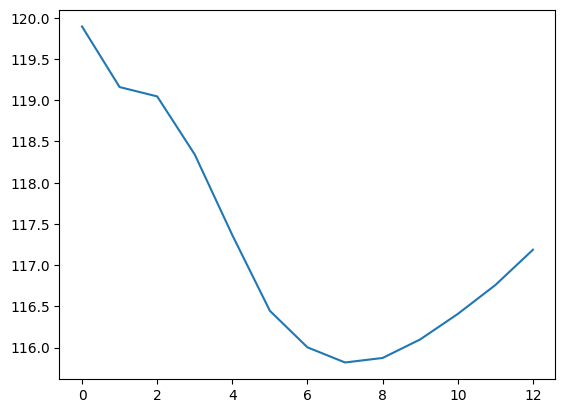

In [8]:
val_data_path = f"{path}/data/{datatype}/valid_data_{sub_datatype}.pkl"
with open(val_data_path, "rb") as f:
    val_data = pickle.load(f)
data = val_data["inputs"]
activations = compute_model_activations(model, data, device)
curvature = compute_model_curvature(activations)
curve = 180 / np.pi * curvature["curve"]
plt.plot(np.nanmean(curve, axis=1))
plt.show()